# Shapley Value Attribution for Tabular Models

This document provides a formal, academic presentation of Shapley value attributions for feed-forward neural networks on tabular data. We derive the Shapley definition, present an unbiased Monte Carlo estimator for ground-truth values, describe the SHAP DeepExplainer methodology, and outline a side-by-side bar-chart comparison protocol.

## 1. Introduction
Interpreting feature contributions in tabular models is essential for model transparency. Shapley values, originating from cooperative game theory, offer a principled way to assign each feature its average marginal impact. We demonstrate how to compute exact Shapley attributions via Monte Carlo sampling and approximate them efficiently using the SHAP DeepExplainer.

## 2. Formal Definition
Let:

- $F$ be the number of features  
- $N = \{1, 2, \dots, F\}$ the feature index set  
- $x \in \mathbb{R}^F$ a specific input vector  
- $f : \mathbb{R}^F \to \mathbb{R}$ the model’s scalar output  
- $b \in \mathbb{R}^F$ the baseline vector (e.g., feature means)

For any coalition $S \subseteq N$, define the “masked” input:

$$
x_S[i] =
\begin{cases}
x_i, & \text{if } i \in S \\
b_i, & \text{if } i \notin S
\end{cases}
$$

The Shapley value for feature $i$ is:

$$
\phi_i =
\sum_{S \subseteq N \setminus \{i\}}
\frac{|S|! \, (F - |S| - 1)!}{F!}
\left[ f(x_{S \cup \{i\}}) - f(x_S) \right]
$$

This formula ensures fair averaging of each feature’s marginal contribution across all subsets $S$.

## 3. Unbiased Monte Carlo Estimation
Exact evaluation requires $2^F$ function calls. Instead, approximate by sampling $M$ random coalitions:

1. For $m = 1, \dots, M$, draw $S_m \subseteq N \setminus \{i\}$ by including each feature $j \ne i$ with probability 0.5.  
2. Compute marginal contribution:  
   $$
   d_m = f(x_{S_m \cup \{i\}}) - f(x_{S_m})
   $$
3. Estimate:  
   $$
   \phi_i^{\mathrm{MC}} \approx \frac{1}{M} \sum_{m=1}^M d_m
   $$

By the law of large numbers, $\phi_i^{\mathrm{MC}} \to \phi_i$ as $M \to \infty$.

## 4. SHAP DeepExplainer Method
SHAP’s DeepExplainer uses a background dataset $X_b = \{x'^{(1)}, \dots, x'^{(K)}\}$ to approximate the expected output:

$$
\mathbb{E}[f(x')] \approx \frac{1}{K} \sum_{k=1}^K f(x'^{(k)})
$$

It then computes attributions $\psi_i(x)$ satisfying:

$$
f(x) = \mathbb{E}[f(x')] + \sum_{i=1}^F \psi_i(x)
$$

Non‐linear activations are linearized around each background sample, and backpropagation aggregates contributions. The parameter `check_additivity=False` can be used to relax strict summation checks when necessary.

## 5. Comparative Visualization Protocol
To assess fidelity of $\psi$ against $\phi^{\mathrm{MC}}$:

1. Choose a test instance $x$  
2. Compute $\phi^{\mathrm{MC}}(x) \in \mathbb{R}^F$ via Monte Carlo  
3. Compute $\psi(x) \in \mathbb{R}^F$ with DeepExplainer  
4. Plot two side‐by‐side bar charts:
   - **X‐axis:** feature index $i$  
   - **Y‐axis:** attribution magnitude  
   - **Left chart:** $\phi_i^{\mathrm{MC}}$  
   - **Right chart:** $\psi_i$

Visual agreement indicates high fidelity of the DeepExplainer approximation.

## 6. Discussion
This exposition demonstrates that Shapley attributions apply seamlessly to tabular neural networks. The Monte Carlo estimator provides unbiased “ground truth,” while DeepExplainer offers an efficient, differentiable approximation. Comparative bar‐chart analysis highlights any discrepancies and guides practitioners in evaluating attribution reliability.


100%|██████████| 1/1 [00:00<00:00, 123.89it/s]


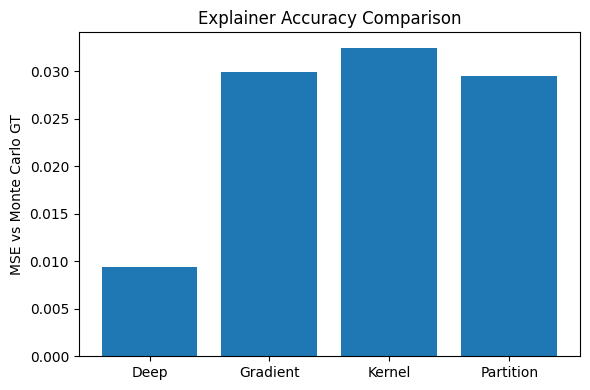

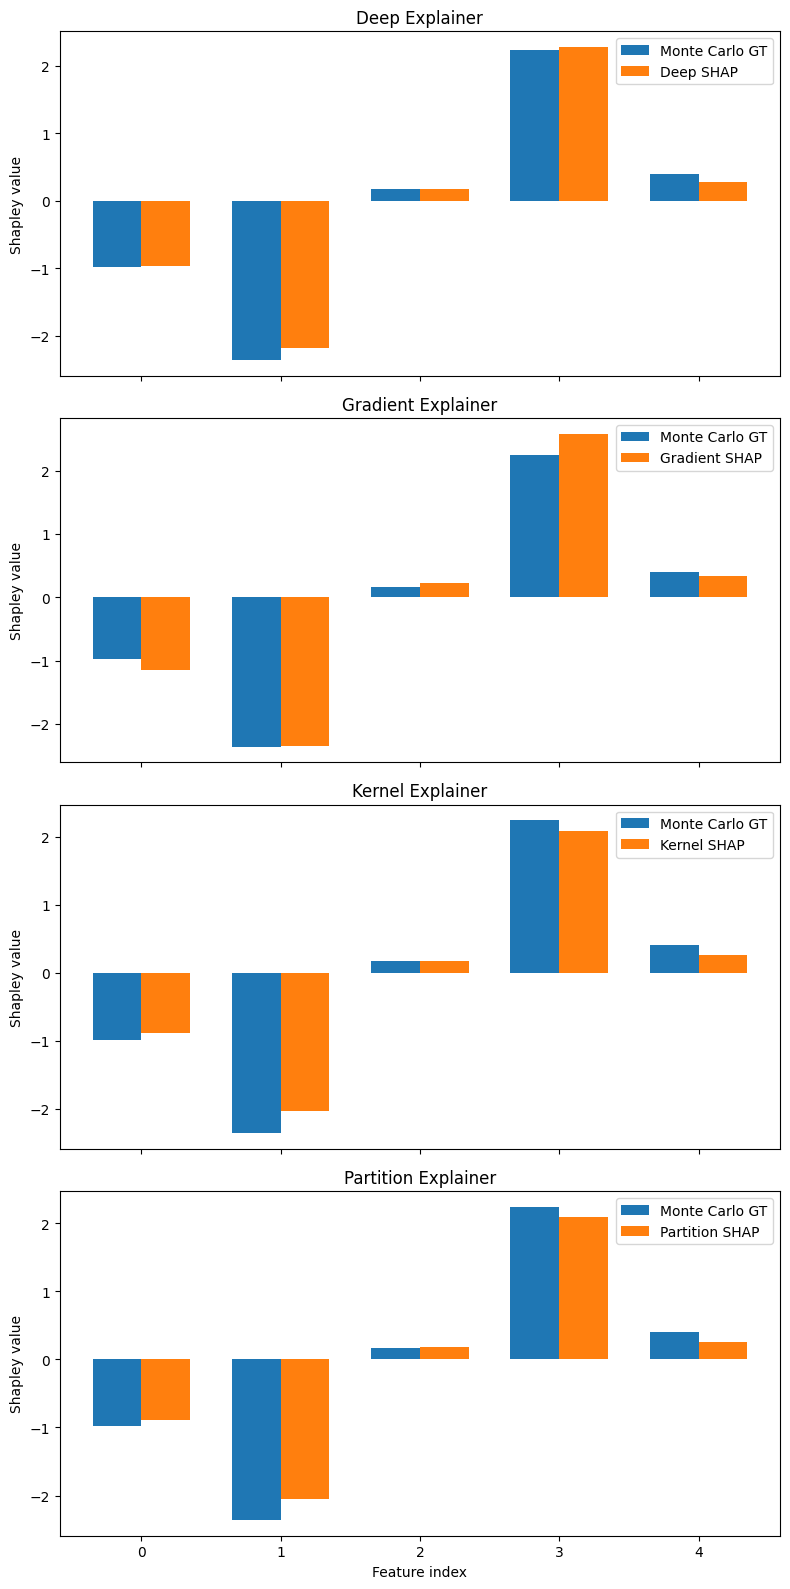

In [17]:
import torch
import torch.nn as nn
import numpy as np
import shap
import matplotlib.pyplot as plt

# 1. Define a simple feed-forward (MLP) model for tabular data
class TabularModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# 2. Synthetic tabular data
n_features = 5
n_samples  = 500
X = np.random.randn(n_samples, n_features)
true_w = np.array([1.5, -2.0, 0.5, 3.0, -1.0])
y = X.dot(true_w)  # no noise

# 3. Train the MLP
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = TabularModel(n_features, hidden_dim=16, output_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn   = nn.MSELoss()

X_t = torch.tensor(X, dtype=torch.float32).to(device)
y_t = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    loss_fn(model(X_t), y_t).backward()
    optimizer.step()

# 4. Select one test instance and baseline
x_test     = X[0]
x_baseline = X.mean(axis=0)

# 5. Ground-truth Shapley via Monte Carlo sampling
def compute_shapley_gt_tabular(model, x, baseline, nsamples=1000):
    F = x.shape[0]
    shap_vals = np.zeros(F)
    model.eval()
    with torch.no_grad():
        for i in range(F):
            contribs = []
            for _ in range(nsamples):
                mask = np.random.rand(F) < 0.5
                mask_with    = mask.copy(); mask_with[i]    = True
                mask_without = mask.copy(); mask_without[i] = False
                def apply_mask(m):
                    x_mask = baseline.copy()
                    x_mask[m] = x[m]
                    inp = torch.tensor(x_mask[None], dtype=torch.float32).to(device)
                    return model(inp).cpu().numpy().squeeze()
                contribs.append(apply_mask(mask_with) - apply_mask(mask_without))
            shap_vals[i] = np.mean(contribs)
    return shap_vals

shap_gt = compute_shapley_gt_tabular(model, x_test, x_baseline)

# 6. Prepare for explainers
background_pt = torch.tensor(X[:100], dtype=torch.float32).to(device)
def f_numpy(flat_x):
    # flat_x: (batch, features)
    with torch.no_grad():
        return model(torch.tensor(flat_x, dtype=torch.float32).to(device)).cpu().numpy()

# 7. Instantiate all four explainers
explainers = {
    "Deep":      shap.DeepExplainer(model, background_pt),
    "Gradient":  shap.GradientExplainer(model, background_pt),
    "Kernel":    shap.KernelExplainer(f_numpy, X[:100]),
    "Partition": shap.PartitionExplainer(f_numpy, X[:100]),
}

# 8. Compute SHAP attributions for each explainer
shap_models = {}
for name, expl in explainers.items():
    if name == "Deep":
        raw = expl.shap_values(
            torch.tensor(x_test[None], dtype=torch.float32).to(device),
            check_additivity=False
        )
        vals = raw[0].flatten()
    elif name == "Gradient":
        raw = expl.shap_values(
            torch.tensor(x_test[None], dtype=torch.float32).to(device)
        )
        vals = raw[0].flatten()
    elif name == "Kernel":
        raw = expl.shap_values(x_test.reshape(1, -1))
        vals = np.array(raw).flatten()
    else:  # Partition
        out  = expl(x_test.reshape(1, -1))
        vals = out.values.flatten()
    shap_models[name] = vals

# 9. Plot MSE comparison across explainers
mses = {name: np.mean((vals - shap_gt)**2) for name, vals in shap_models.items()}
plt.figure(figsize=(6,4))
plt.bar(mses.keys(), mses.values())
plt.ylabel('MSE vs Monte Carlo GT')
plt.title('Explainer Accuracy Comparison')
plt.tight_layout()
plt.show()

# 10. Plot feature-level comparisons
n_explainers = len(shap_models)
fig, axes = plt.subplots(n_explainers, 1, figsize=(8, 4 * n_explainers), sharex=True)

features = np.arange(n_features)
width    = 0.35

for ax, (name, vals) in zip(axes, shap_models.items()):
    ax.bar(features - width/2, shap_gt, width, label='Monte Carlo GT')
    ax.bar(features + width/2, vals, width, label=f'{name} SHAP')
    ax.set_title(f'{name} Explainer')
    ax.set_ylabel('Shapley value')
    ax.legend()

axes[-1].set_xlabel('Feature index')
plt.tight_layout()
plt.show()


